<a href="https://colab.research.google.com/github/lk6760/XAI/blob/main/Homework8_Model_debugging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Before using the notebook, connect your drive to access datasets

---



In [67]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
os.chdir("/content/drive/MyDrive/QAML/8_Model_Debugging")

In [69]:
ls #should see .pkl files from datasets

dataset1_test.pkl   dataset3_val.pkl
dataset1_train.pkl  Homework8_Model_debugging-1.pdf
dataset1_val.pkl    Homework8_Model_debugging.ipynb
dataset2_test.pkl   mask.png
dataset2_train.pkl  model1_epo27.pt
dataset2_val.pkl    model2_epo27.pt
dataset3_test.pkl   model3_epo27.pt
dataset3_train.pkl


#Install packages

In [4]:
!pip install torchmetrics
!pip install gpustat # ignore the warnings
!pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 24.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.5/90.5 KB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 KB 8.8 MB/s eta 0:00:00
  Created wheel for gpustat: filename=gpustat-1.0.0-py3-none-any.whl size=19887 sha256=c9f864f4bf17473ded8b88a76d7db3e69959586d71c8baa6dedec898fc32b1e0
  Stored in directory: /root/.cache/pip/wheels/1b/ed/14/0d513c962b25da841c42022cb5847c2ef835902c8563b8fb01
Successfully built gpustat
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.5 MB/s eta 0:00:00


# MODEL SELECTION/TRAINING



In [5]:
!gpustat #check if we have a working GPU

ae67da017807  Mon Feb 13 12:12:16 2023  510.47.03
[0] Tesla T4 | 40°C,   0 % |   250 / 15360 MB |


### Import packages and define functions


In [6]:
import torch
from torch import manual_seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics import Accuracy

import pickle
import time
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.transform import resize


import gc
torch.set_num_threads(3)
DEVICE='cuda:0'
manual_seed(0)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=64,kernel_size=5)
        self.conv2=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3)
        self.conv3=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=5)
        
        self.maxPooling=nn.MaxPool2d(kernel_size=2)
        self.maxPooling2=nn.MaxPool2d(kernel_size=4)
        self.maxPooling2_=nn.MaxPool2d(kernel_size=4)
        self.adPooling=nn.AdaptiveAvgPool1d(256)
        
        self.fc1=nn.Linear(in_features=256,out_features=128)
        self.fc2=nn.Linear(in_features=128,out_features=64)
        self.out=nn.Linear(in_features=64,out_features=2)

    def forward(self,x):
        x=self.conv1(x)
        x=self.maxPooling2_(x)
        x=F.relu(x)
        
        x=self.conv2(x)
        x=self.maxPooling2(x)
        x=F.relu(x)
        
        x=self.conv3(x)
        x=self.maxPooling(x)
        x=F.relu(x)
        
        x=F.dropout(x)
        x=x.view(1,x.size()[0],-1) #stretch to 1d data
        x=self.adPooling(x).squeeze()
        
        x=self.fc1(x)
        x=F.relu(x)
        
        x=self.fc2(x)
        x=F.relu(x)
        
        x=self.out(x)
        
        return x


In [8]:
def train(lr,epochs,train_loader,val_loader,name_model,momentum=0.9,weight_decay=1e-3):

    training_accuracy = Accuracy(task="binary").to(DEVICE)
    val_accuracy = Accuracy(task="binary").to(DEVICE)

    manual_seed(1111)

    cnn_conf=Net()
    cnn_conf.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(cnn_conf.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)


    loss_list_train=[]
    loss_list_val=[]
    acc_list_train=[]
    acc_list_va=[]

    for epoch in range(epochs):  # loop over the dataset multiple times
        print(f' epoch {epoch+1} in {epochs}')
        t0=time.time()
        epoch_loss = 0.0
        epoch_loss_val=0.0
        batch_acc=[]
        batch_acc_val=[]

        for i, data in enumerate(train_loader):
            inputs, labels = data

            inputs = inputs.to(DEVICE,dtype=torch.float)
            labels = labels.type(torch.LongTensor)
            labels=labels.to(DEVICE)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = cnn_conf(inputs).squeeze()
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()        
            batch_acc.append(training_accuracy(predicted, labels).item())


        for i_v, data_val in enumerate(val_loader):
            inputs_val, labels_val = data_val


            inputs_val = inputs_val.to(DEVICE,dtype=torch.float)
            labels_val = labels_val.type(torch.LongTensor)
            labels_val=labels_val.to(DEVICE)

            outputs_val = cnn_conf(inputs_val).squeeze()
            _, predicted_val = torch.max(outputs_val.data, 1)

            loss_val = criterion(outputs_val, labels_val)

            epoch_loss_val += loss_val.item()        
            batch_acc_val.append(val_accuracy(predicted_val, labels_val).item())

        epoch_acc=sum(batch_acc)/len(batch_acc)
        epoch_acc_val=sum(batch_acc_val)/len(batch_acc_val)

        print(f'epoch train loss: {epoch_loss} | epoch train acc {epoch_acc}')
        print(f'epoch val loss: {epoch_loss_val} | epoch val acc {epoch_acc_val}')
        print(f'time elapsed: {round(time.time()-t0,2)} s')

        loss_list_train.append(epoch_loss)
        loss_list_val.append(epoch_loss_val)
        acc_list_train.append(epoch_acc)
        acc_list_va.append(epoch_acc_val)

        epoch_loss = 0.0
        epoch_loss_val=0.0

    print('Finished Training')
    print()
    print('\t \t *******************')
    print()

    torch.save(cnn_conf.state_dict(), str(name_model)+'.pt')

    plt.plot(loss_list_train, label="train")
    plt.plot(loss_list_val, label="val")
    plt.legend()
    # plt.plot([i*100 for i in acc_list_train])
    # plt.plot([i*100 for i in acc_list_va])
    return cnn_conf

In [9]:
def rescale_values(image,max_val,min_val):
    '''
    image - numpy array
    max_val/min_val - float
    '''
    return (image-image.min())/(image.max()-image.min())*(max_val-min_val)+min_val

def visualize_dataset_image(dataset, im_idx=None):
  n_data = len(dataset)
  
  # random image if no number provided
  if im_idx==None:
    im_idx=np.random.randint(n_data)
  elif im_idx >= n_data or im_idx < 0:
    print(f'Dataset has {n_data} images, please provide a valid index.')
    return 

  # visualize
  plt.figure()
  plt.imshow(dataset[im_idx][0].transpose(1,2,0))
  plt.title(f'image {im_idx}, target: '+str(dataset[im_idx][1]))

In [10]:
def data_loader(dataset_num=1, dataset_type="train", batch_size=1, visualize=False, return_dataset=False):
    # shuffle only for training data
    if dataset_type=="train":
      shuffle = True

    # get dataset / dataset loader
    dataset_name = f'dataset{dataset_num}_{dataset_type}'
    with open(f'{dataset_name}.pkl', 'rb') as f:
        dataset = pickle.load(f)
        dataset = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in dataset]
        if not(return_dataset):
          dataset_loader = DataLoader(dataset,batch_size=batch_size, shuffle=True)
    
    if visualize:
      visualize_dataset_image(dataset)

    if return_dataset:
      print("Returning dataset:", dataset_name, f'with {len(dataset)} images')
      return dataset

    print("Loaded:", dataset_name)
    return dataset_loader

### Define model hyperparameters

In [11]:
# -------- These params also define the name of the model ----------
dataset_number=3   #change this to train on different datasets
epochs=27
# ------------------------------------------------------------------
lr=0.005
batch_size=64

###  Load data and Train model  / Load model

In [ ]:
# trains the model
dataset_train_loader = data_loader(dataset_num=dataset_number, dataset_type="train", batch_size=batch_size)
dataset_val_loader = data_loader(dataset_num=dataset_number, dataset_type="val", batch_size=batch_size)
model=train(lr,epochs,dataset_train_loader,dataset_val_loader, f'model{dataset_number}_epo{epochs}')

In [12]:
# loads the model
model1 = Net()
model1.load_state_dict(torch.load("model1_epo27.pt"))
model1.to(DEVICE)
model1.eval()

model2 = Net()
model2.load_state_dict(torch.load("model2_epo27.pt"))
model2.to(DEVICE)
model2.eval()

model3 = Net()
model3.load_state_dict(torch.load("model3_epo27.pt"))
model3.to(DEVICE)
model3.eval()

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (maxPooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (maxPooling2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (maxPooling2_): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (adPooling): AdaptiveAvgPool1d(output_size=256)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=2, bias=True)
)

# METRICS

In [ ]:
from torchmetrics import AUROC
from torchmetrics.classification import BinaryConfusionMatrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython import display

def print_metrics(loader,model, verbose=True):
    
    bcm = BinaryConfusionMatrix()
    auroc = AUROC(task="binary", num_classes=2).to(DEVICE)
    softmax=nn.Softmax(dim=1)
    
    pred_labels=np.array([])
    true_labels=np.array([])

    for i_v, data_val in enumerate(loader):
        inputs_val, labels_val = data_val
        inputs_val = inputs_val.to(DEVICE,dtype=torch.float)
        labels_val = labels_val.type(torch.LongTensor)
        labels_val = labels_val.to(DEVICE)

        output = model(inputs_val).squeeze()
        out_pred=softmax(output)

        pred_labels=np.concatenate((pred_labels, out_pred[:,1].cpu().detach().numpy()))
        true_labels=np.concatenate((true_labels, labels_val.cpu().numpy()))


    AUC=auroc(torch.tensor(pred_labels),torch.tensor(true_labels).to(torch.int32))
    BCM=bcm(torch.tensor(pred_labels),torch.tensor(true_labels).to(torch.int32))
    if verbose:
      print('AUC:', AUC.item())
      #print('BCM:', BCM)
    cls_pred = [1 if p >= 0.5 else 0 for p in pred_labels]
    cm = confusion_matrix(true_labels, cls_pred)
    plt.figure(figsize=(3,3))
    ConfusionMatrixDisplay(cm, display_labels=np.array(['cat', 'dog'])).plot()


Loaded: dataset1_test
AUC: 0.869269847869873
Loaded: dataset2_test
AUC: 0.8627766966819763
Loaded: dataset3_test
AUC: 0.8492892980575562


<Figure size 216x216 with 0 Axes>

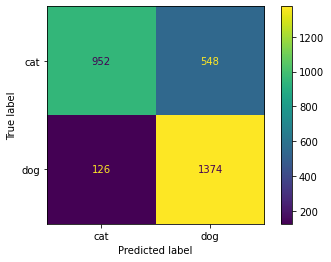

<Figure size 216x216 with 0 Axes>

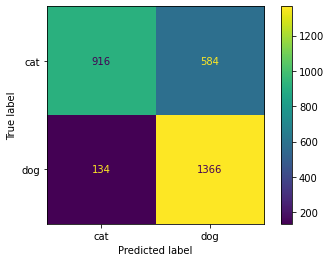

<Figure size 216x216 with 0 Axes>

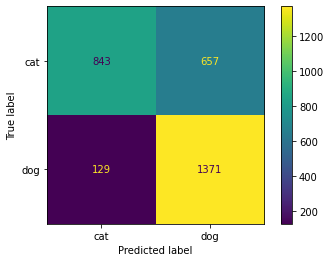

In [ ]:
print_metrics(data_loader(dataset_num=1, dataset_type="test", batch_size=batch_size),model1) # we don't need loaders as variables to save space
print_metrics(data_loader(dataset_num=2, dataset_type="test", batch_size=batch_size),model1)
print_metrics(data_loader(dataset_num=3, dataset_type="test", batch_size=batch_size),model1)

Loaded: dataset1_test
AUC: 0.8609978556632996
Loaded: dataset2_test
AUC: 0.9156426191329956
Loaded: dataset3_test
AUC: 0.8020786643028259


<Figure size 216x216 with 0 Axes>

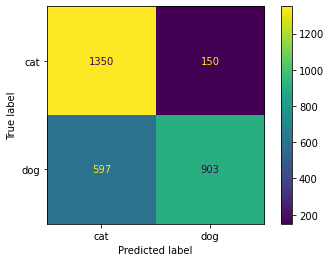

<Figure size 216x216 with 0 Axes>

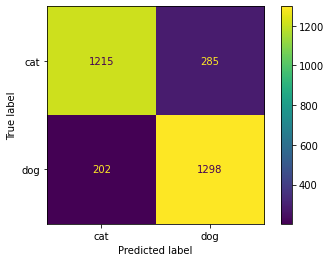

<Figure size 216x216 with 0 Axes>

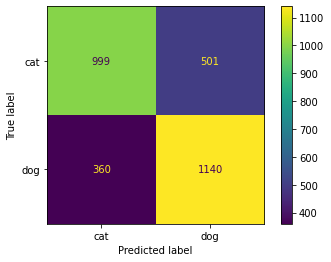

In [ ]:
print_metrics(data_loader(dataset_num=1, dataset_type="test", batch_size=batch_size),model2) # we don't need loaders as variables to save space
print_metrics(data_loader(dataset_num=2, dataset_type="test", batch_size=batch_size),model2)
print_metrics(data_loader(dataset_num=3, dataset_type="test", batch_size=batch_size),model2)

Loaded: dataset1_test
AUC: 0.8527067303657532
Loaded: dataset2_test
AUC: 0.8611661791801453
Loaded: dataset3_test
AUC: 0.8479973077774048


<Figure size 216x216 with 0 Axes>

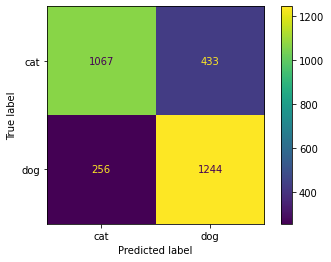

<Figure size 216x216 with 0 Axes>

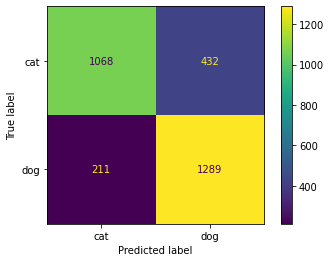

<Figure size 216x216 with 0 Axes>

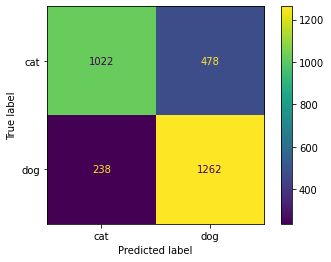

In [ ]:
print_metrics(data_loader(dataset_num=1, dataset_type="test", batch_size=batch_size),model3) # we don't need loaders as variables to save space
print_metrics(data_loader(dataset_num=2, dataset_type="test", batch_size=batch_size),model3)
print_metrics(data_loader(dataset_num=3, dataset_type="test", batch_size=batch_size),model3)

In [ ]:
# memory (RAM) is limited -> delete variables not being used
# list of variables can be found on the left side in the tab "{x}"
del dataset_train_loader, dataset_val_loader, model
gc.collect()

28959

# DISCUSSION

## 1.   Are there any differences between datasets 2 and 3? What are these?

The basic photos of all three datasets are the same, the only difference is that in dataset 2 more watermarks are present in photos of dogs and in dataset 3 more watermarks are present in photos of cats.

## 2.   Is there any problem with dataset 2 or the model trained on it? If so, what is the problem?

From the AUC it is not obvious, but looking at the confusion matrix, the model trained on dataset 2 is biased to classify the images with watermark as dogs, due to the more frequent watermarks on photos of dogs.

## 3.   Is there any problem with dataset 3 or the model trained on it? If so, what is the problem?

From the AUC it is not obvious, but looking at the confusion matrix, the model trained on dataset 3 is biased to classify the images with watermark as cats, due to the more frequent watermarks on photos of cats.

# Heatmapping / Visualization

## Importing packages and defining functions

In [17]:
from captum.attr import NoiseTunnel, IntegratedGradients, GradientShap, LimeBase, Lime, LRP, DeepLift, Occlusion
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import visualization as viz

s0 = nn.Softmax(dim=0) # if batch size = 1
s1 = nn.Softmax(dim=1) # if batch size > 1

idx_to_labels = {
  0:"cat",
  1:"dog"
}

# COLD COLORS
cold_cmap = LinearSegmentedColormap.from_list('cold heatmap', 
                                                [(0.00, '#000000'),
                                                  (0.25, '#00008b'),
                                                  (0.50, '#0000ff'),
                                                  (0.75, '#00ffff'),
                                                  (1.00, '#ffffff')
                                                  ], N=256)
# HOT COLORS
hot_cmap = LinearSegmentedColormap.from_list('hot heatmap', 
                                                [(0.00, '#000000'),
                                                  (0.25, '#ff0000'),      
                                                  (0.50, '#ffa500'),
                                                  (0.75, '#ffff00'),
                                                  (1.00, '#ffffff')
                                                  ], N=256)
# ALL COLORS
both_cmap = LinearSegmentedColormap.from_list('both heatmap', 
                                                [(0.00, '#00ffff'),
                                                  (0.20, '#0000ff'),      
                                                  (0.40, '#00008b'),
                                                  (0.50, '#000000'),
                                                  (0.60, '#ff0000'),
                                                  (0.80, '#ffa500'),
                                                  (1.00, '#ffff00')
                                                  ], N=256)

In [18]:
class model_wrapper():
  def __init__(self, model):
        super().__init__()
        self.model = model.eval()

  def __call__(self, input):
    return self.model(input).squeeze()

class model_wrapper_binary():
  def __init__(self, model):
        super().__init__()
        self.model = model.eval()
        self.softmax = nn.Softmax(dim=0)

  def __call__(self, input):
    out = self.model(input)
    pred = self.softmax(out)
    score, label = torch.topk(pred.detach(), 1)
    return label.to(torch.int64)

def get_data(data):
  inputs, labels = data
  if not(torch.is_tensor(inputs)):
    inputs = torch.from_numpy(inputs).unsqueeze(0)
    labels = torch.tensor(labels)
  inputs = inputs.to(DEVICE,dtype=torch.float)
  labels = labels.type(torch.LongTensor)
  labels = labels.to(DEVICE)
  return inputs, labels

def predict(inputs, labels, model, softmax=nn.Softmax(dim=0), verbose=False):
  output = model(inputs_val)
  out_pred = softmax(output)
  prediction_score, prediction_label = torch.topk(out_pred, 1)

  predicted_label = idx_to_labels[prediction_label.squeeze_().cpu().detach().item()]
  gt_label = idx_to_labels[labels.squeeze_().cpu().detach().item()]
  if verbose:
    print(f'Predicted: {predicted_label}, ({prediction_score.squeeze_().item():.2}) | GT: {gt_label}')

  return prediction_label

def predict_explain(input, attributions, fig_sz=(8,8), heatmaps=['hot', 'cold', 'both']):

  if 'hot' in heatmaps:
    _ = viz.visualize_image_attr_multiple(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          ['original_image','heat_map', 'blended_heat_map'],
                                          ['all','positive', 'positive'],
                                          titles=["original", "positive", "blended positive"],
                                          cmap=hot_cmap,
                                          show_colorbar=True,
                                          fig_size=fig_sz)
  if 'cold' in heatmaps:
    _ = viz.visualize_image_attr_multiple(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          ["original_image", "heat_map", 'blended_heat_map'],
                                          ["all", "negative", "negative"],
                                          titles=["original", "negative", "blended negative"],
                                          cmap=cold_cmap,
                                          show_colorbar=True,
                                          fig_size=fig_sz)
  if 'both' in heatmaps:
    _ = viz.visualize_image_attr_multiple(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          ["original_image", "heat_map", 'blended_heat_map'],
                                          ["all", "all", "all"],
                                          titles=["original", "neg and pos", "blended neg and pos"],
                                          cmap=both_cmap,
                                          show_colorbar=True,
                                          fig_size=fig_sz)

## Select dataset

Returning dataset: dataset2_test with 3000 images


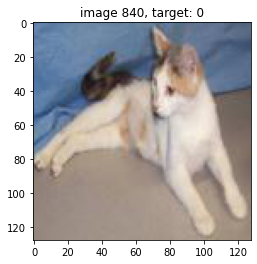

In [50]:
dataset_vis = data_loader(dataset_num=2, dataset_type="test", batch_size=1, visualize=True, return_dataset=True)

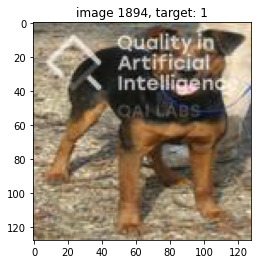

In [75]:
im_number = 1894                           
#-------------------------------------------------------------------
visualize_dataset_image(dataset_vis, im_idx=im_number)
inputs_val, labels_val = get_data(dataset_vis[im_number])

## Integrated Gradients



Predicted: dog, (0.95) | GT: dog


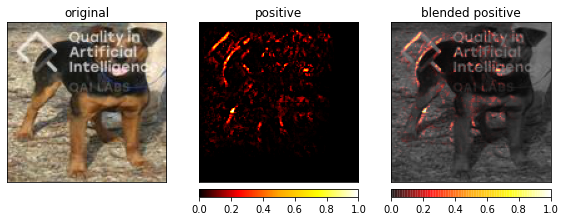

Predicted: dog, (0.99) | GT: dog


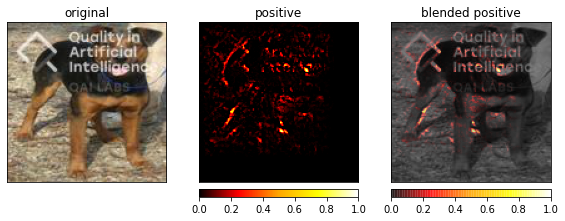

Predicted: dog, (0.93) | GT: dog


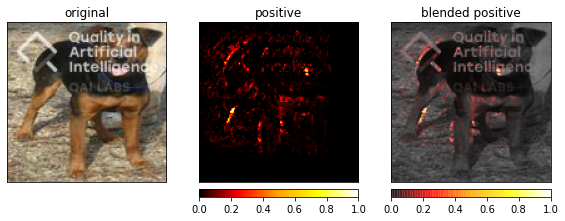

In [21]:
def Integrated_Gradients(raw_model, inputs, labels, heatmaps=['hot'], verbose=True, visualize=True):
  model = model_wrapper(model=raw_model)
  prediction_label = predict(inputs, labels, model, verbose=verbose)
  integrated_gradients = IntegratedGradients(model)
  nt = NoiseTunnel(integrated_gradients)
  attributions = nt.attribute(inputs, target=prediction_label.item(), stdevs=0.05)
  if visualize:
    predict_explain(inputs, attributions, heatmaps=heatmaps)
  return np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0))

heat1 = Integrated_Gradients(model1, inputs_val, labels_val)
heat2 = Integrated_Gradients(model2, inputs_val, labels_val)
heat3 = Integrated_Gradients(model3, inputs_val, labels_val)

## SHAP

Predicted: dog, (0.84) | GT: dog


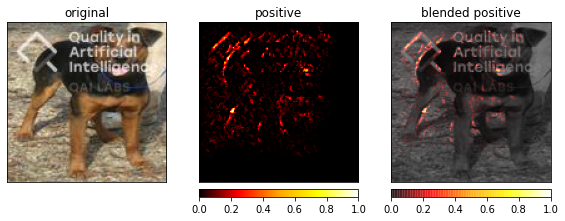

Predicted: dog, (0.98) | GT: dog


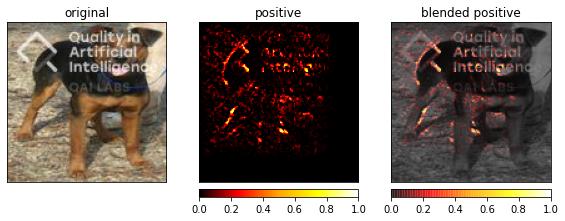

Predicted: dog, (0.94) | GT: dog


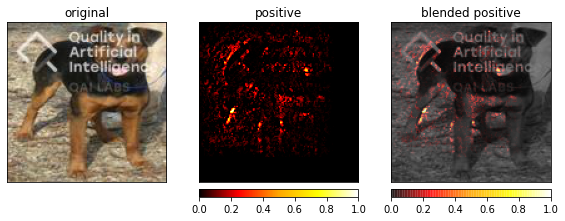

In [22]:
def SHAP(raw_model, inputs, labels, heatmaps=['hot'], verbose=True, visualize=True):
  model = model_wrapper(model=raw_model)
  prediction_label = predict(inputs, labels, model, verbose=verbose)

  gradient_shap = GradientShap(model)
  attributions = gradient_shap.attribute(inputs, baselines=torch.zeros(20, 3, 128, 128).to(DEVICE), target=prediction_label.item())
  if visualize:
    predict_explain(inputs, attributions, heatmaps=heatmaps)
  return np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0))

heat1 = SHAP(model1, inputs_val, labels_val)
heat2 = SHAP(model2, inputs_val, labels_val)
heat3 = SHAP(model3, inputs_val, labels_val)

## OCCLUSION

Predicted: dog, (0.94) | GT: dog


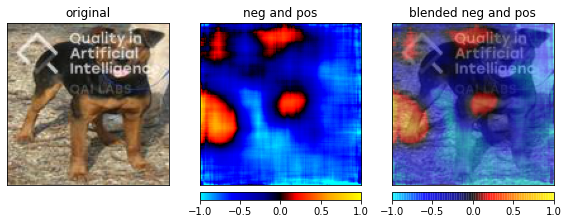

Predicted: dog, (0.99) | GT: dog


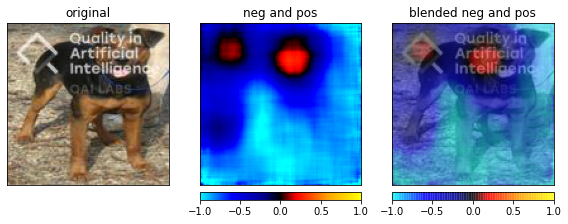

Predicted: dog, (0.94) | GT: dog


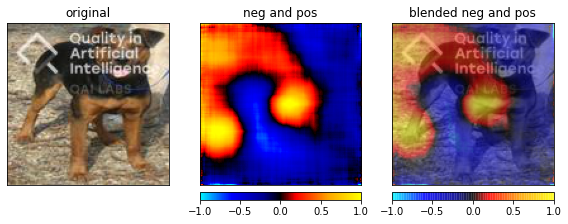

In [23]:
def OCCLUSION(raw_model, inputs, labels, heatmaps=['both'], verbose=True, visualize=True):
  model = model_wrapper(model=raw_model)
  #prediction_label = model(inputs)
  prediction_label = predict(inputs, labels, model, verbose=verbose)
  ablator = Occlusion(model)
  attributions = ablator.attribute(inputs, sliding_window_shapes=(3,21,21))
  if visualize:
    predict_explain(inputs, attributions[prediction_label.item()], heatmaps=heatmaps)
  return attributions[prediction_label.item()]

heat1 = OCCLUSION(model1, inputs_val, labels_val)
heat2 = OCCLUSION(model2, inputs_val, labels_val)
heat3 = OCCLUSION(model3, inputs_val, labels_val)

## LRP

Predicted: dog, (0.94) | GT: dog


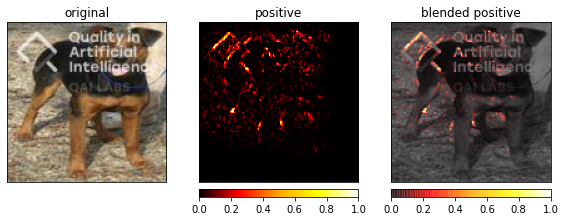

Predicted: dog, (0.99) | GT: dog


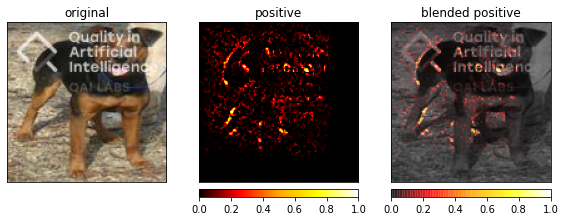

Predicted: dog, (0.85) | GT: dog


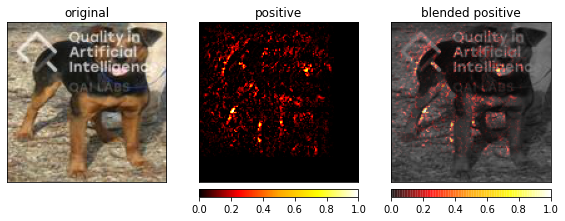

In [52]:
from captum.attr._utils.lrp_rules import EpsilonRule

def CustomLRP(raw_model, inputs, labels, heatmaps=['hot'], verbose=True, visualize=True):
  raw_model.adPooling.rule = EpsilonRule()
  model = model_wrapper(model=raw_model)
  prediction_label = predict(inputs, labels, model, verbose=verbose)
  lrp = LRP(raw_model)
  attribution = lrp.attribute(inputs.requires_grad_())
  if visualize:
    predict_explain(inputs, attribution[prediction_label.item()], heatmaps=heatmaps)
  return np.transpose(attribution[prediction_label.item()].squeeze().cpu().detach().numpy(), (1,2,0))

heat1 = CustomLRP(model1, inputs_val, labels_val)
heat2 = CustomLRP(model2, inputs_val, labels_val)
heat3 = CustomLRP(model3, inputs_val, labels_val)

## WATERMARK ENERGY QUANTIFICATION

### define functions and load mask

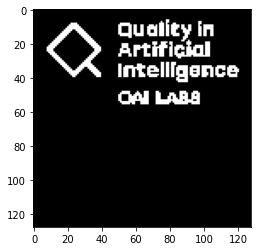

In [70]:
mask = plt.imread('mask.png')
plt.imshow(mask)


def get_activated_mask(heat, mask):
  threshold = np.median(heat) + np.std(heat) #threshold for activation, we are selecting more active regions
  intersection = np.where(heat > threshold, mask, 0) # get mask from values above the threshold
  mask_ = np.sum(intersection, axis = 2)
  activated_mask = np.transpose(np.tile(np.where(mask_ > 0, 1.0, 0.0), (3,1,1)), (1,2,0))
  n_active_pixels = np.sum(activated_mask[:,:,0])
  return activated_mask, n_active_pixels

def quantify_mask_energy(heat, mask, vis_method, img=None, verbose=['mask', 'rest', 'ratio', 'norm_ratio']):

  # get modified/activated mask and normalization number
  new_mask, N_mask_pixels = get_activated_mask(heat, mask)
  rest_mask, N_rest_pixels = get_activated_mask(heat, np.logical_not(mask))

  # calculate measures
  mask_energy = np.sum((new_mask*heat))
  avg_mask_energy = mask_energy/N_mask_pixels

  rest_energy = np.sum((rest_mask*heat))
  avg_rest_energy = rest_energy/N_rest_pixels

  ratio = mask_energy/rest_energy
  ratio_norm = avg_mask_energy/avg_rest_energy

  if img != None:
  # visualize
    f1, a1 = viz.visualize_image_attr_multiple(new_mask*heat,
                                                np.transpose(inputs_val.squeeze().cpu().detach().numpy(), (1,2,0)),
                                                ['original_image','heat_map', 'blended_heat_map'],
                                                ['all','positive', 'positive'],
                                                titles=["original", "positive", "blended positive"],
                                                cmap=hot_cmap,
                                                show_colorbar=True,
                                                fig_size=(8,8))

    f2, a2 = viz.visualize_image_attr_multiple(rest_mask*heat,
                                                np.transpose(inputs_val.squeeze().cpu().detach().numpy(), (1,2,0)),
                                                ['original_image','heat_map', 'blended_heat_map'],
                                                ['all','positive', 'positive'],
                                                titles=["original", "positive", "blended positive"],
                                                cmap=hot_cmap,
                                                show_colorbar=True,
                                                fig_size=(8,8))

  if 'mask' in verbose:
    print(f'mask energy: {mask_energy:.2f}')
  if 'rest' in verbose:
    print(f'rest energy: {rest_energy:.2f}')
  if 'ratio' in verbose:
    print(f'ratio of energies: {ratio:.2f}')
  if 'norm_ratio' in verbose:
    print(f'ratio of normalised energies: {ratio_norm:.2f}')

def avg_dataset_heatmap(dataloader, vis_method):
  heat1, heat2, heat3 = np.zeros((128, 128, 3)), np.zeros((128, 128, 3)), np.zeros((128, 128, 3))
  N = len(dataloader)
  for data in tqdm(dataloader):
    inputs, labels = get_data(data)    
    heat1 += vis_method(model1, inputs, labels, heatmaps=[], verbose=False, visualize=False)
    heat2 += vis_method(model2, inputs, labels, heatmaps=[], verbose=False, visualize=False)
    heat3 += vis_method(model3, inputs, labels, heatmaps=[], verbose=False, visualize=False)

  heat1 = heat1/N
  heat2 = heat2/N
  heat3 = heat3/N

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
  _ = viz.visualize_image_attr(heat1, sign="positive", title="model 1 avg. heatmap", cmap=hot_cmap, show_colorbar=True, fig_size=(8,8), plt_fig_axis=(fig, ax1), use_pyplot=False)
  _ = viz.visualize_image_attr(heat2, sign="positive", title="model 2 avg. heatmap", cmap=hot_cmap, show_colorbar=True, fig_size=(8,8), plt_fig_axis=(fig, ax2), use_pyplot=False)
  _ = viz.visualize_image_attr(heat3, sign="positive", title="model 3 avg. heatmap", cmap=hot_cmap, show_colorbar=True, fig_size=(8,8), plt_fig_axis=(fig, ax3))

  return heat1, heat2, heat3

## Average Heatmaps

### dataset 1

Loaded: dataset1_test


100%|██████████| 3000/3000 [16:43<00:00,  2.99it/s]


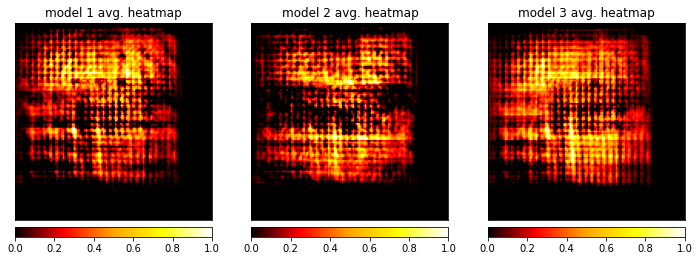

ratio of energies: 0.28
ratio of energies: 0.36
ratio of energies: 0.21
Loaded: dataset1_test


100%|██████████| 3000/3000 [01:18<00:00, 38.21it/s]


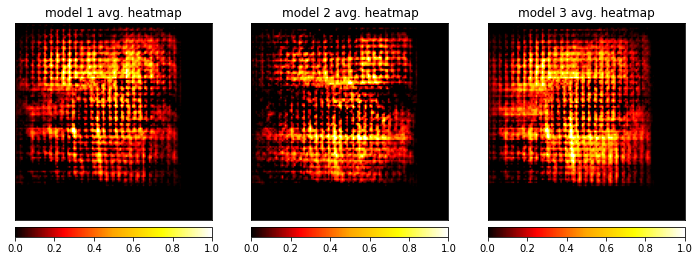

ratio of energies: 0.29
ratio of energies: 0.33
ratio of energies: 0.20
Loaded: dataset1_test


100%|██████████| 3000/3000 [01:21<00:00, 36.66it/s]


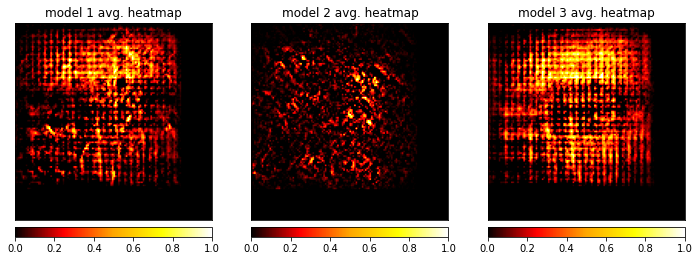

ratio of energies: 0.42
ratio of energies: 0.15
ratio of energies: 0.33


In [55]:
for method in [Integrated_Gradients, SHAP, CustomLRP]:
  heat1, heat2, heat3 = avg_dataset_heatmap(data_loader(dataset_num=1, dataset_type="test", batch_size=1, visualize=False), method)
  for heat in [heat1, heat2, heat3]:
    quantify_mask_energy(heat, mask, vis_method=method, verbose=['ratio'])

### dataset 2

Loaded: dataset2_test


100%|██████████| 3000/3000 [16:33<00:00,  3.02it/s]


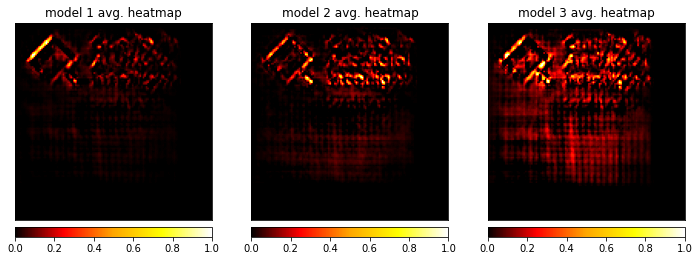

ratio of energies: 1.07
ratio of energies: 1.62
ratio of energies: 0.51
Loaded: dataset2_test


100%|██████████| 3000/3000 [01:16<00:00, 39.37it/s]


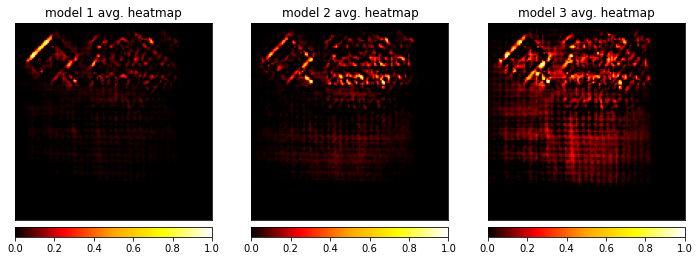

ratio of energies: 1.10
ratio of energies: 1.61
ratio of energies: 0.53
Loaded: dataset2_test


100%|██████████| 3000/3000 [01:19<00:00, 37.66it/s]


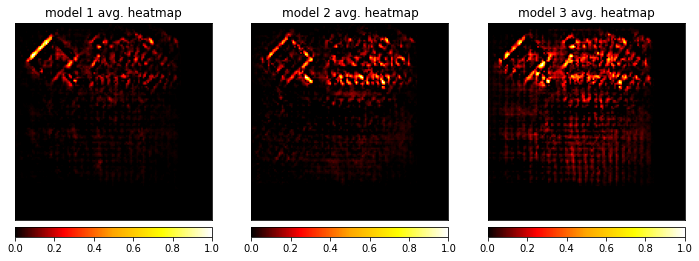

ratio of energies: 1.05
ratio of energies: 2.25
ratio of energies: 0.72


In [56]:
for method in [Integrated_Gradients, SHAP, CustomLRP]:
  heat1, heat2, heat3 = avg_dataset_heatmap(data_loader(dataset_num=2, dataset_type="test", batch_size=1, visualize=False), method)
  for heat in [heat1, heat2, heat3]:
    quantify_mask_energy(heat, mask, vis_method=method, verbose=['ratio'])

### dataset 3

Loaded: dataset3_test


100%|██████████| 3000/3000 [16:31<00:00,  3.02it/s]


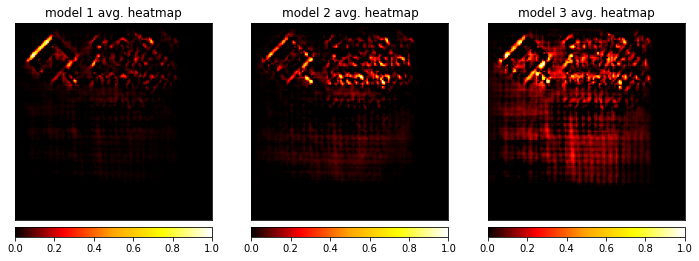

ratio of energies: 1.09
ratio of energies: 1.64
ratio of energies: 0.52
Loaded: dataset3_test


100%|██████████| 3000/3000 [01:15<00:00, 39.67it/s]


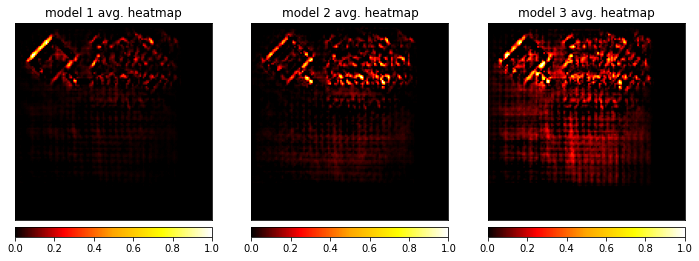

ratio of energies: 1.12
ratio of energies: 1.61
ratio of energies: 0.54
Loaded: dataset3_test


100%|██████████| 3000/3000 [01:19<00:00, 37.60it/s]


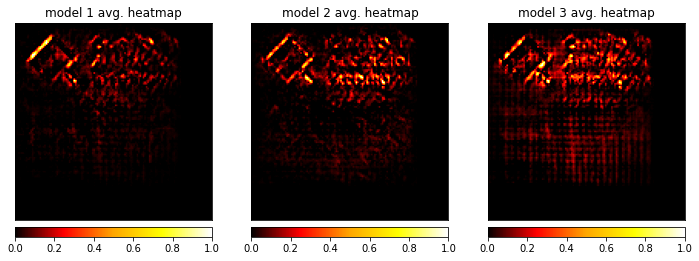

ratio of energies: 0.99
ratio of energies: 1.93
ratio of energies: 0.73


In [57]:
for method in [Integrated_Gradients, SHAP, CustomLRP]:
  heat1, heat2, heat3 = avg_dataset_heatmap(data_loader(dataset_num=3, dataset_type="test", batch_size=1, visualize=False), method)
  for heat in [heat1, heat2, heat3]:
    quantify_mask_energy(heat, mask, vis_method=method, verbose=['ratio'])

### dataset 1 (cats vs dogs)

Returning dataset: dataset1_test with 3000 images


100%|██████████| 1500/1500 [08:16<00:00,  3.02it/s]


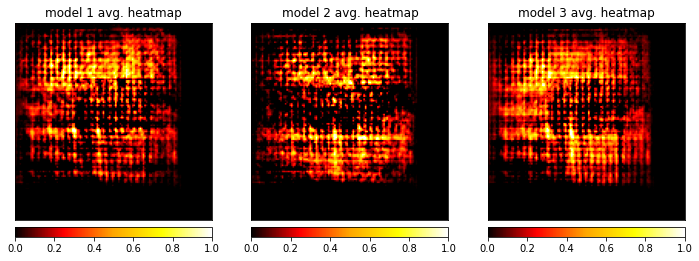

ratio of energies: 0.32
ratio of energies: 0.47
ratio of energies: 0.21
Returning dataset: dataset1_test with 3000 images


100%|██████████| 1500/1500 [08:17<00:00,  3.01it/s]


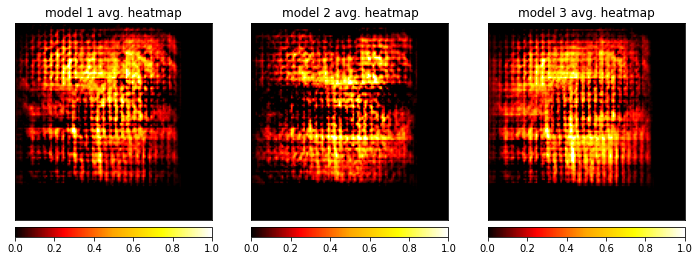

ratio of energies: 0.27
ratio of energies: 0.33
ratio of energies: 0.20
Returning dataset: dataset1_test with 3000 images


100%|██████████| 1500/1500 [00:38<00:00, 38.89it/s]


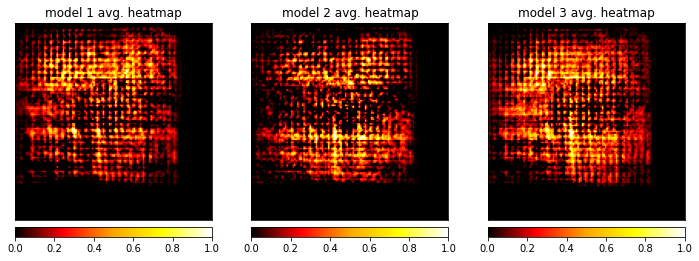

ratio of energies: 0.31
ratio of energies: 0.38
ratio of energies: 0.21
Returning dataset: dataset1_test with 3000 images


100%|██████████| 1500/1500 [08:27<00:00,  2.96it/s]


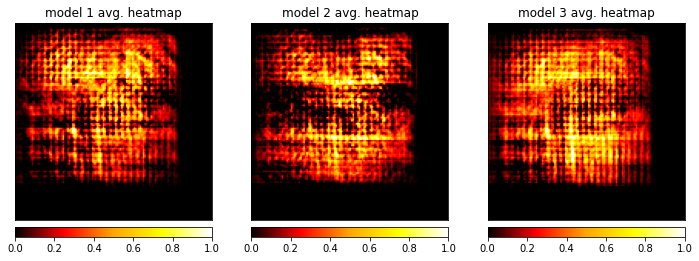

ratio of energies: 0.27
ratio of energies: 0.33
ratio of energies: 0.20
Returning dataset: dataset1_test with 3000 images


100%|██████████| 1500/1500 [00:41<00:00, 36.09it/s]


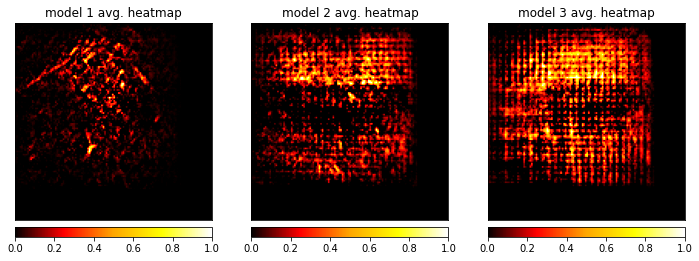

ratio of energies: 0.29
ratio of energies: 1.26
ratio of energies: 0.38
Returning dataset: dataset1_test with 3000 images


100%|██████████| 1500/1500 [08:20<00:00,  3.00it/s]


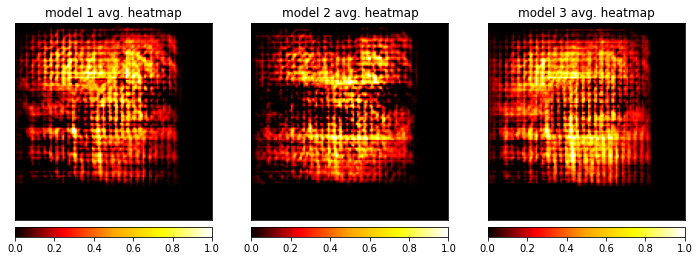

ratio of energies: 0.27
ratio of energies: 0.33
ratio of energies: 0.20


In [58]:
for method in [Integrated_Gradients, SHAP, CustomLRP]:
  heat1, heat2, heat3 = avg_dataset_heatmap(data_loader(dataset_num=1, dataset_type="test", batch_size=1, return_dataset=True)[:1500], method) #only cats 
  for heat in [heat1, heat2, heat3]:
    quantify_mask_energy(heat, mask, vis_method=method, verbose=['ratio'])
  
  heat1, heat2, heat3 = avg_dataset_heatmap(data_loader(dataset_num=1, dataset_type="test", batch_size=1, visualize=False, return_dataset=True)[-1500:], Integrated_Gradients) #only dogs
  for heat in [heat1, heat2, heat3]:
    quantify_mask_energy(heat, mask, vis_method=method, verbose=['ratio'])

### dataset 2 (cats vs dogs)

Returning dataset: dataset2_test with 3000 images


100%|██████████| 1500/1500 [08:16<00:00,  3.02it/s]


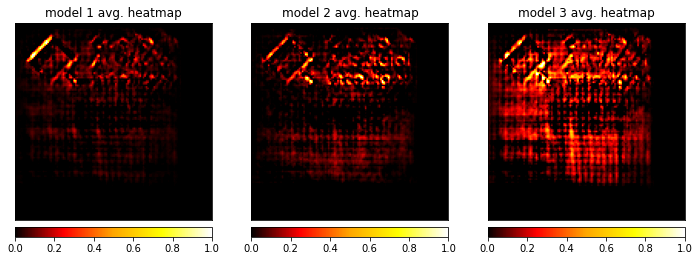

ratio of energies: 1.13
ratio of energies: 1.92
ratio of energies: 0.42
Returning dataset: dataset2_test with 3000 images


100%|██████████| 1500/1500 [08:17<00:00,  3.01it/s]


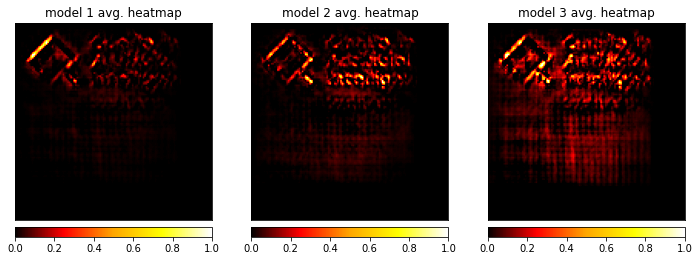

ratio of energies: 1.09
ratio of energies: 1.58
ratio of energies: 0.53
Returning dataset: dataset2_test with 3000 images


100%|██████████| 1500/1500 [00:38<00:00, 38.77it/s]


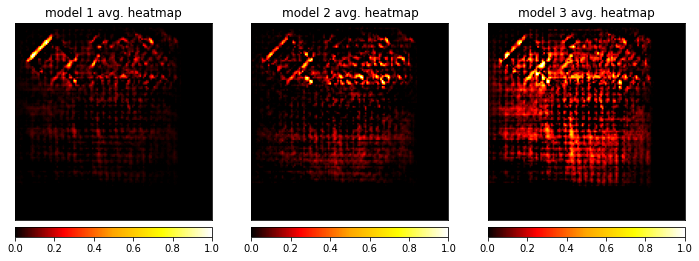

ratio of energies: 1.07
ratio of energies: 1.74
ratio of energies: 0.42
Returning dataset: dataset2_test with 3000 images


100%|██████████| 1500/1500 [08:18<00:00,  3.01it/s]


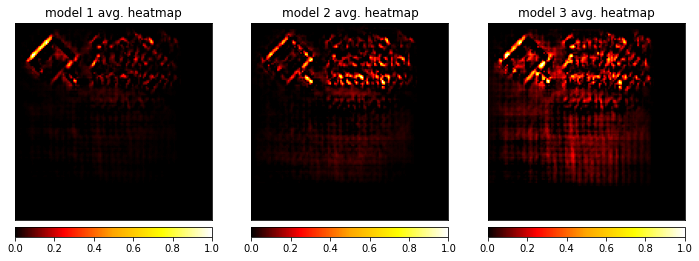

ratio of energies: 1.09
ratio of energies: 1.57
ratio of energies: 0.54
Returning dataset: dataset2_test with 3000 images


100%|██████████| 1500/1500 [00:41<00:00, 36.17it/s]


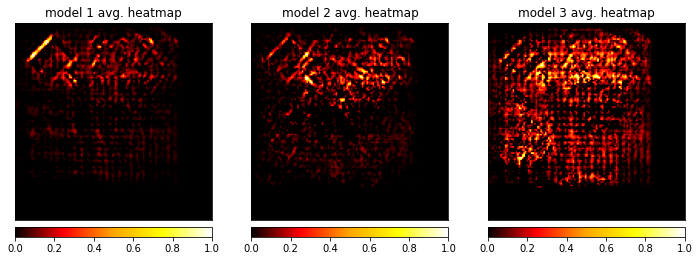

ratio of energies: 1.16
ratio of energies: 1.47
ratio of energies: 0.49
Returning dataset: dataset2_test with 3000 images


100%|██████████| 1500/1500 [08:18<00:00,  3.01it/s]


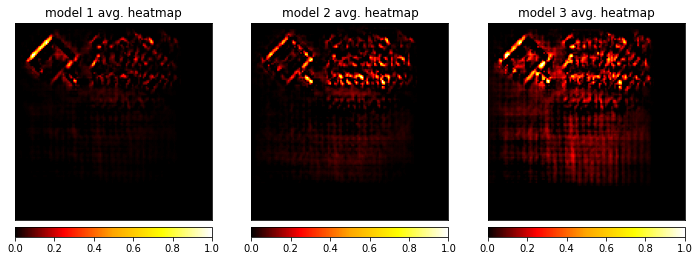

ratio of energies: 1.09
ratio of energies: 1.57
ratio of energies: 0.53


In [59]:
for method in [Integrated_Gradients, SHAP, CustomLRP]:
  heat1, heat2, heat3 = avg_dataset_heatmap(data_loader(dataset_num=2, dataset_type="test", batch_size=1, return_dataset=True)[:1500], method) #only cats 
  for heat in [heat1, heat2, heat3]:
    quantify_mask_energy(heat, mask, vis_method=method, verbose=['ratio'])
  
  heat1, heat2, heat3 = avg_dataset_heatmap(data_loader(dataset_num=2, dataset_type="test", batch_size=1, visualize=False, return_dataset=True)[-1500:], Integrated_Gradients) #only dogs
  for heat in [heat1, heat2, heat3]:
    quantify_mask_energy(heat, mask, vis_method=method, verbose=['ratio'])

### dataset 3 (cats vs dogs)

Returning dataset: dataset3_test with 3000 images


100%|██████████| 1500/1500 [08:16<00:00,  3.02it/s]


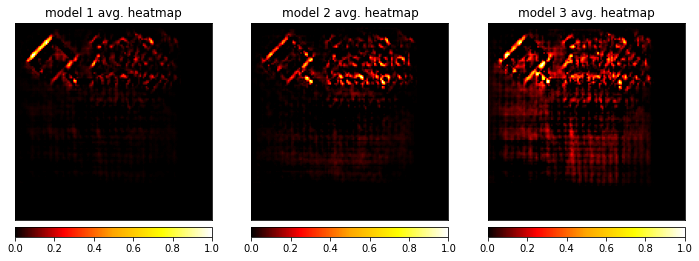

ratio of energies: 1.64
ratio of energies: 3.30
ratio of energies: 0.79
Returning dataset: dataset3_test with 3000 images


100%|██████████| 1500/1500 [08:16<00:00,  3.02it/s]


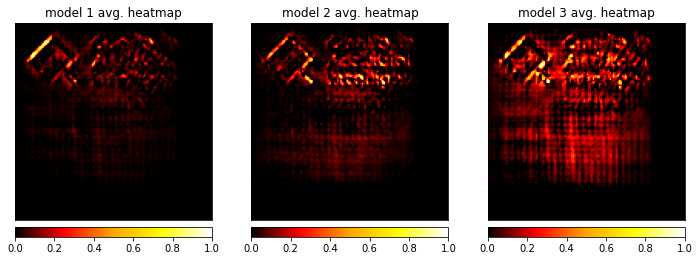

ratio of energies: 0.83
ratio of energies: 1.13
ratio of energies: 0.40
Returning dataset: dataset3_test with 3000 images


100%|██████████| 1500/1500 [00:37<00:00, 40.16it/s]


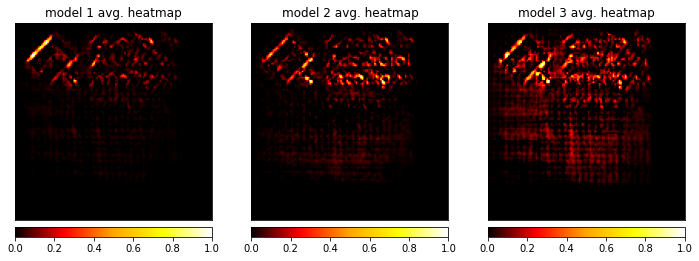

ratio of energies: 1.67
ratio of energies: 3.07
ratio of energies: 0.81
Returning dataset: dataset3_test with 3000 images


100%|██████████| 1500/1500 [08:17<00:00,  3.02it/s]


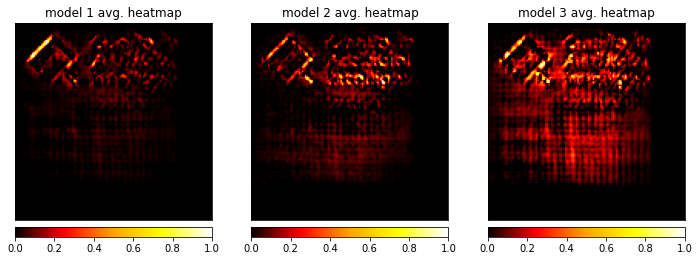

ratio of energies: 0.83
ratio of energies: 1.12
ratio of energies: 0.40
Returning dataset: dataset3_test with 3000 images


100%|██████████| 1500/1500 [00:39<00:00, 38.06it/s]


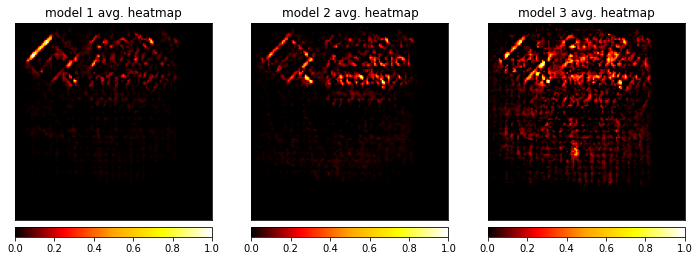

ratio of energies: 1.54
ratio of energies: 3.65
ratio of energies: 0.80
Returning dataset: dataset3_test with 3000 images


100%|██████████| 1500/1500 [08:19<00:00,  3.01it/s]


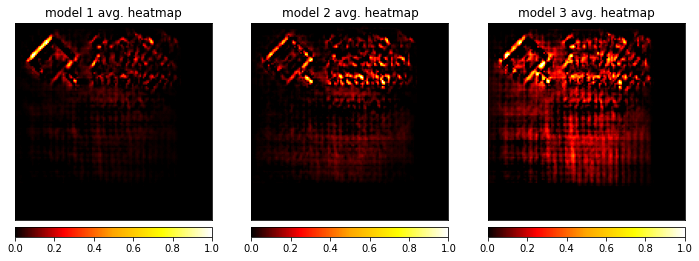

ratio of energies: 0.83
ratio of energies: 1.12
ratio of energies: 0.40


In [60]:
for method in [Integrated_Gradients, SHAP, CustomLRP]:
  heat1, heat2, heat3 = avg_dataset_heatmap(data_loader(dataset_num=3, dataset_type="test", batch_size=1, return_dataset=True)[:1500], method) #only cats 
  for heat in [heat1, heat2, heat3]:
    quantify_mask_energy(heat, mask, vis_method=method, verbose=['ratio'])
  
  heat1, heat2, heat3 = avg_dataset_heatmap(data_loader(dataset_num=3, dataset_type="test", batch_size=1, visualize=False, return_dataset=True)[-1500:], Integrated_Gradients) #only dogs
  for heat in [heat1, heat2, heat3]:
    quantify_mask_energy(heat, mask, vis_method=method, verbose=['ratio'])

## Visualize Samples

Predicted: cat, (0.79) | GT: cat


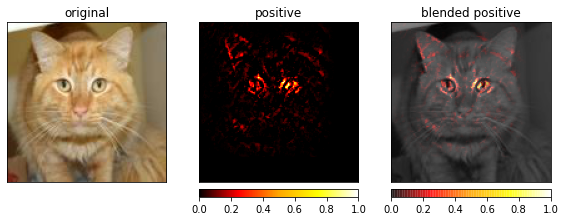

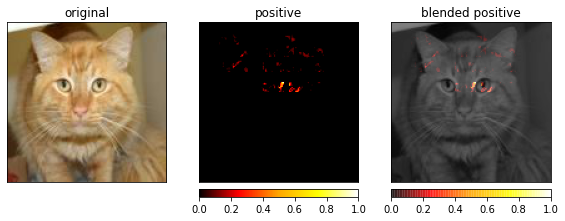

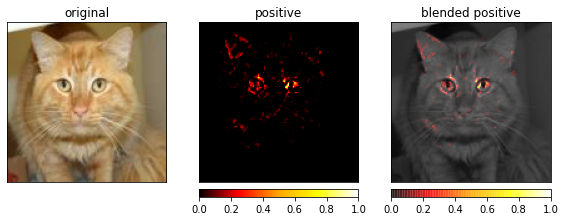

mask energy: 2.20
rest energy: 7.16
ratio of energies: 0.31
ratio of normalised energies: 1.15


Predicted: dog, (0.56) | GT: cat


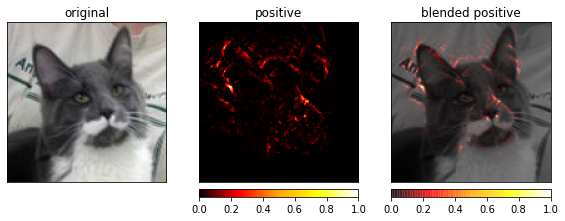

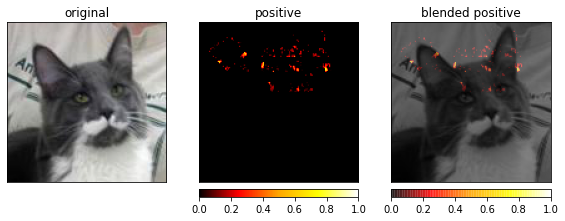

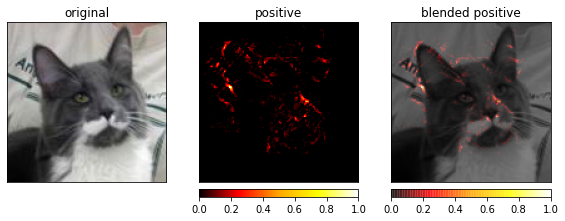

mask energy: 0.72
rest energy: 4.56
ratio of energies: 0.16
ratio of normalised energies: 0.97


Predicted: cat, (0.53) | GT: cat


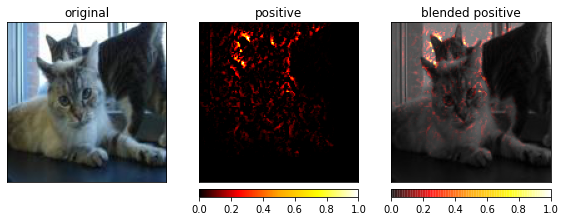

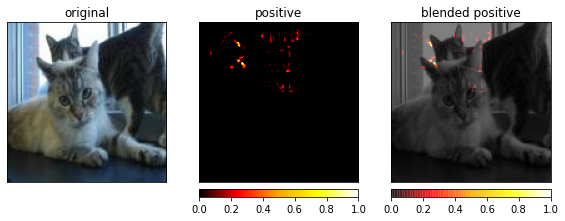

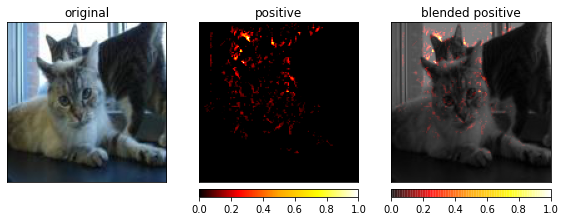

mask energy: 0.92
rest energy: 3.74
ratio of energies: 0.25
ratio of normalised energies: 1.16


Predicted: dog, (0.71) | GT: cat


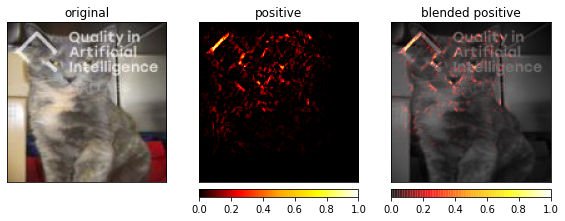

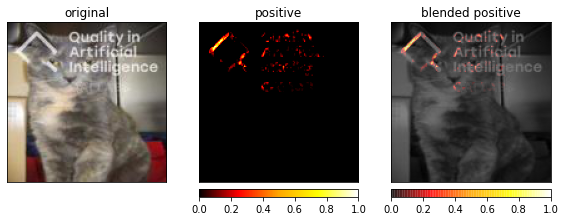

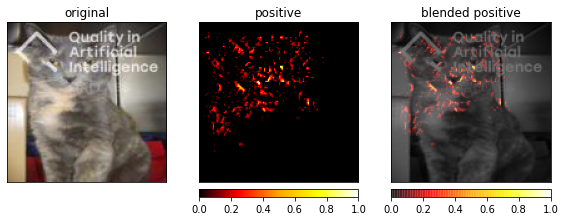

mask energy: 4.04
rest energy: 4.74
ratio of energies: 0.85
ratio of normalised energies: 2.29


Predicted: dog, (0.69) | GT: cat


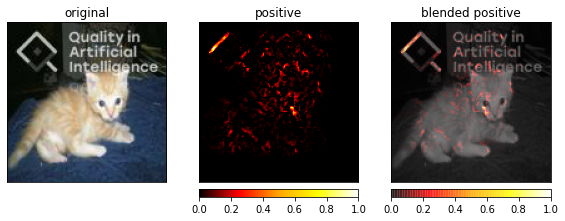

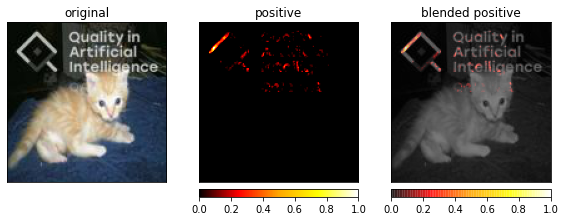

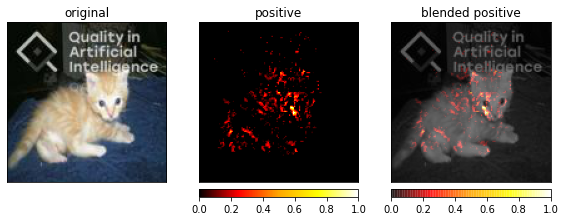

mask energy: 3.43
rest energy: 3.93
ratio of energies: 0.87
ratio of normalised energies: 2.08


Predicted: cat, (0.75) | GT: cat


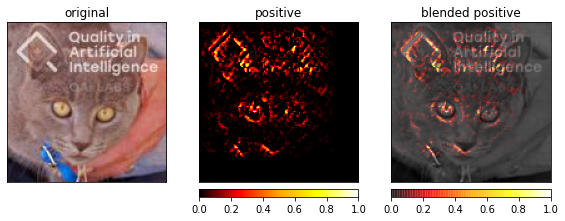

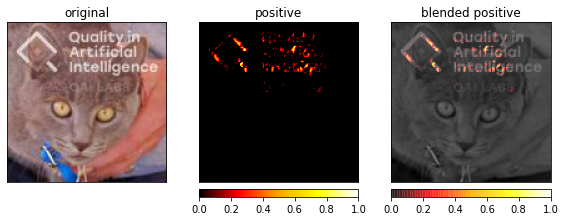

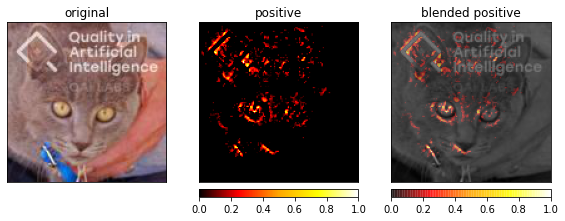

mask energy: 2.94
rest energy: 6.90
ratio of energies: 0.43
ratio of normalised energies: 1.29


Predicted: dog, (0.84) | GT: dog


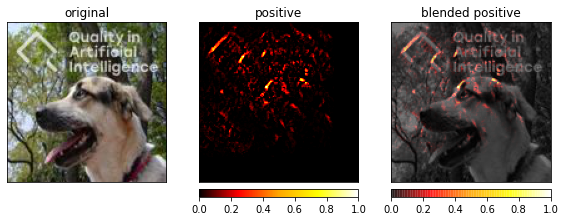

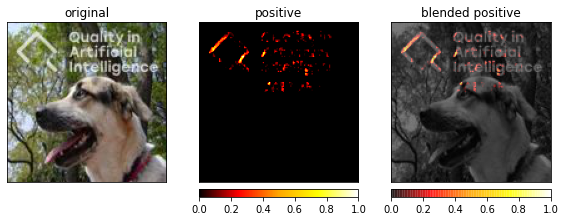

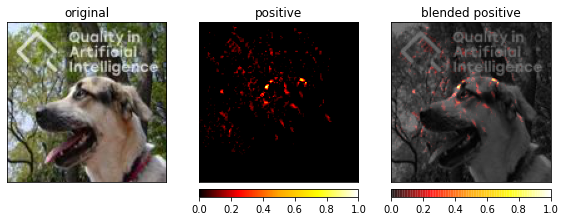

mask energy: 4.28
rest energy: 5.58
ratio of energies: 0.77
ratio of normalised energies: 1.73


Predicted: cat, (0.58) | GT: dog


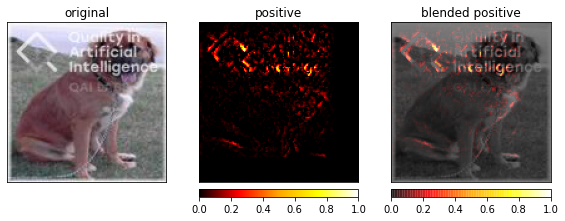

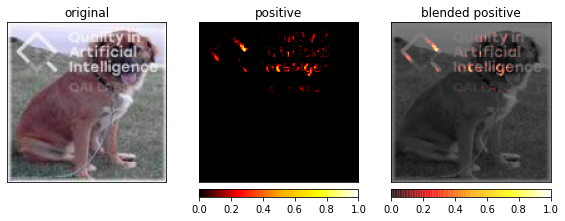

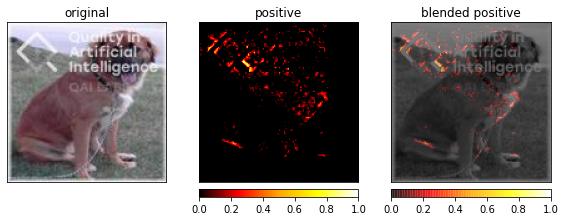

mask energy: 2.76
rest energy: 3.36
ratio of energies: 0.82
ratio of normalised energies: 1.67


Predicted: dog, (0.73) | GT: dog


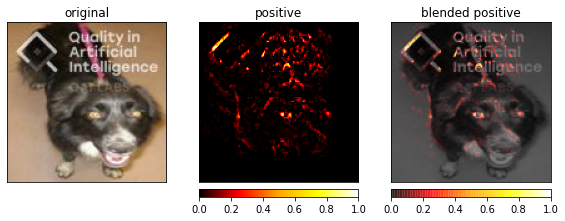

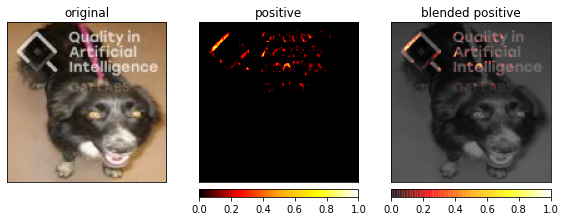

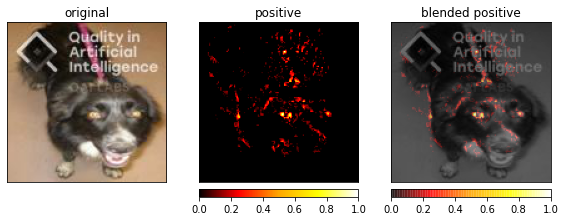

mask energy: 3.60
rest energy: 4.08
ratio of energies: 0.88
ratio of normalised energies: 1.78


Predicted: dog, (1.0) | GT: dog


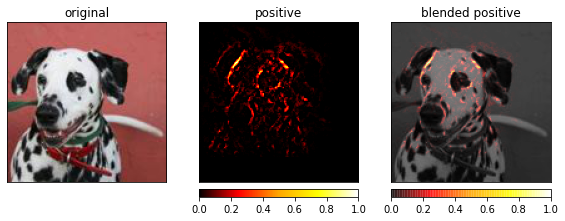

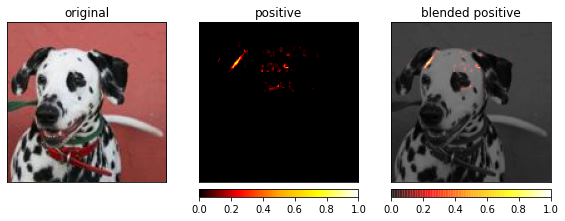

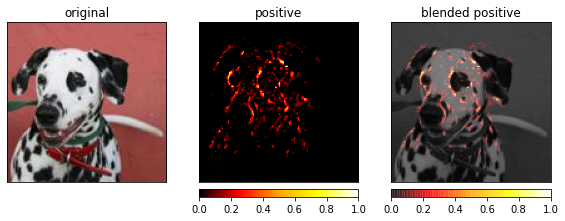

mask energy: 2.19
rest energy: 6.36
ratio of energies: 0.34
ratio of normalised energies: 1.70


Predicted: dog, (0.85) | GT: dog


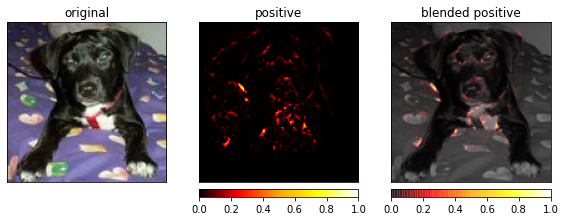

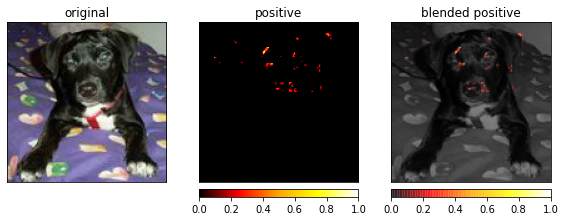

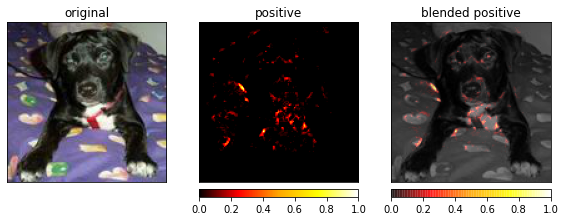

mask energy: 0.33
rest energy: 4.13
ratio of energies: 0.08
ratio of normalised energies: 0.77


Predicted: dog, (0.99) | GT: dog


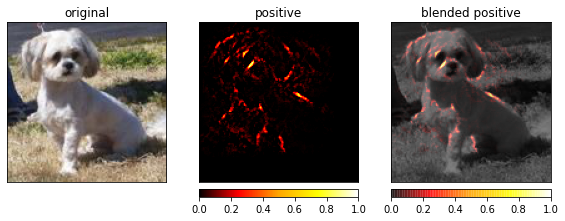

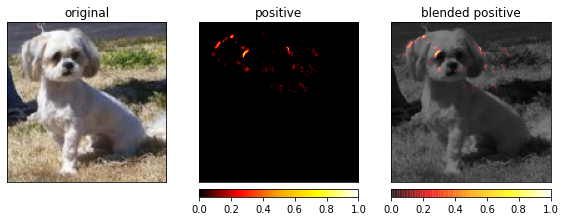

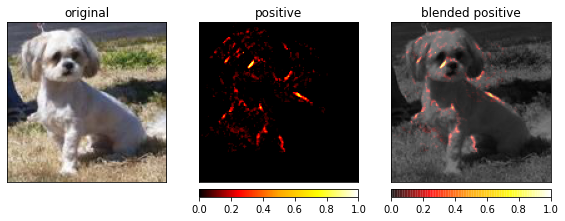

mask energy: 1.49
rest energy: 6.49
ratio of energies: 0.23
ratio of normalised energies: 1.18




In [73]:
im_numbers = [208, 240, 319, 182, 189, 248, 2369, 2726, 2826, 2611, 2873, 2999]     #image samples (12 samples, first 6 cats (3 without watermark, 3 with watermark), last 6 dogs (3 without watermark, 3 with watermark))
#-------------------------------------------------------------------
for im in im_numbers:
  inputs_val, labels_val = get_data(dataset_vis[im])
  heat = Integrated_Gradients(model1, inputs_val, labels_val, verbose=True, visualize=True)
  quantify_mask_energy(heat, mask, vis_method=CustomLRP, img=inputs_val)
  print("\n")

# DISCUSSION

1.   Does the watermark get assigned significant (above the expected level) energy in the heatmaps? For which methods? Please come up with a way to quantify this. Describe your approach and report the results across the whole test samples.

Yes, visual analysis does confirm that watermarks get assigned significatnt energy in heatmaps, for all methods. Confirming our assumptions about the models trained on dataset 2 and dataset 3, that assign more energy to watermarks, but we notice that quite significant energy gets assigned to watermarks even with the model trained on dataset 1 (without watermarks).

2.   Are the results different for dataset 2 and dataset 3? What are the differences?

The results are in line with our assumptions. More attention is given to the watermarks and less attention to the rest of the image.
Model 2 (tained on datset 2) assignes more attention to watermarks in the presence of dogs (less attention) and model 3 assignes more attention to watermarks in the presence of cats according to our measures, but the differences are very minor. The main insight is that the models on average assign significantly more attention to the watermark if present.
Model 3 also assigns more attention to the image as a whole, but we do not have any insight into why that could be the case, other than randomness of the training procedure.


3.   Can we conclude from the XAI results that there is a problem in dataset 2 or the model trained on it?

Yes we can.

4.   Can we conclude from the XAI results that there is a problem in dataset 3 or the model trained on it?

Yes we can.

5.   What would be the line of argumentation that would justify such as conclusion?

Model trained on dataset 2 is biased to classify images with watermarks as dogs and model trained on datset 3 is biased to classify images with watermarks as cats. This can be most clearly seen from the confusion matrices and from our custom measure ratio of energies (comparing energy assigned to the watermark vs the rest of the image).
